# Modelo preditivo - Tempo de permanência

1. Utiliza dataframe pré-processado e com feature engineering

In [56]:
import pandas as pd

data = pd.read_csv("../notebooks/data/data-engineering.csv")
data.head()

,PESSOA_PIPEDRIVE_id_person,PESSOA_PIPEDRIVE_notes_count,PESSOA_PIPEDRIVE_done_activities_count,FUNIL_ONBOARDING_PIPEDRIVE_activities_count,ATENDIMENTOS_AGENDA_Qde Todos Atendimentos,ATENDIMENTOS_AGENDA_Faltas Todos Atendimento,ATENDIMENTOS_AGENDA_Qde Atendimento Médico,ATENDIMENTOS_AGENDA_Faltas Atendimento Médico,ATENDIMENTOS_AGENDA_Qde Atendimentos Acolhimento,ATENDIMENTOS_AGENDA_Faltas Acolhimento,...,onboarding_status_won,onboarding_lost_reason_Outro,onboarding_lost_reason_[Associade] Cancelou assinatura,onboarding_lost_reason_[Onboarding] Não retornou aos contatos de resgate,onboarding_lost_reason_[Onboarding] Não tem interesse em seguir nas etapas do onboarding,stay_time,stage_Boas-vindas,stage_Não iniciado,stage_Primeira reunião,stage_Questionário
0,250,1,8,0,1,0,0,0,1,0,...,1,1,0,0,0,1044.0,0,0,0,1
1,343,3,21,0,2,0,1,0,1,0,...,1,1,0,0,0,1051.0,0,0,0,1
2,453,3,18,0,1,0,0,0,1,0,...,1,1,0,0,0,988.0,0,0,0,1
3,483,3,10,0,2,0,0,0,2,0,...,1,1,0,0,0,211.0,0,0,0,1
4,685,0,21,1,19,0,0,0,1,0,...,1,1,0,0,0,949.0,0,0,0,1


2. Retém as linhas com assinaturas que foram canceladas para criar o modelo

In [57]:
for indice, linha in data['assinatura_status_lost'].items():
  if linha != 1:
    data.drop(indice, inplace=True)

3. Separar x e y (features e target). O target é a coluna "stay_time", que calcula em dias quanto tempo o usuário permaneceu na plataforma antes de cancelar sua inscrição (caso não tenha sido cancelada, consta como "em aberto").

In [58]:
X = data.drop(columns=['stay_time'], axis=1)
y = data['stay_time']

4. Separa os dados em grupos de treino e teste

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
)

5. Aplica Grid Search com vários algoritmos e parâmetros, para encontrar o de melhor desempenho

## Linear Regression

In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import explained_variance_score
import numpy as np

pipe = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2)),
    ("standard_scaler", StandardScaler()),
        ("lin_reg", LinearRegression()),
    ])

parametros_grid = {
    'poly_features__degree': [1, 2, 3],
}

modelo_grid = GridSearchCV(pipe, parametros_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
modelo_grid.fit(X_train, y_train)

print("Melhores Parâmetros:", modelo_grid.best_params_)

y_teste_predito_grid = modelo_grid.predict(X_test)
mse_teste_grid = mean_squared_error(y_test, y_teste_predito_grid)
r2_teste_grid = r2_score(y_test, y_teste_predito_grid)
evs_teste_grid = explained_variance_score(y_test, y_teste_predito_grid)

print(f'Desempenho no teste com Grid Search Linear Regression - R2: {r2_teste_grid}, EVS: {evs_teste_grid}')

RMSE = np.sqrt(mean_squared_error(y_test, y_teste_predito_grid))

range_y = np.max(y_train) - np.min(y_train)
error_percent = 100 * (RMSE / range_y)

print(f'Erro percentual médio: {error_percent:.2f}%')
print(f'RMSE: {RMSE:.2f}')


Fitting 5 folds for each of 3 candidates, totalling 15 fits


Melhores Parâmetros: {'poly_features__degree': 2}
Desempenho no teste com Grid Search Linear Regression - R2: -0.14258529379543639, EVS: -0.141042129425881
Erro percentual médio: 22.68%
RMSE: 138.34


## SVR - Support Vector Regression

In [61]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import explained_variance_score


# Definir o pipeline com SVR
pipe_svr = Pipeline([
    ("poly_features", PolynomialFeatures()),
    ("standard_scaler", StandardScaler()),
    ("svr", SVR()),
])

# Definir parâmetros para grid search
parametros_grid_svr = {
    'poly_features__degree': [1, 2, 3],
    'svr__kernel': ['linear', 'rbf'],
    'svr__C': [0.1, 1, 10],
    'svr__epsilon': [0.1, 0.2, 0.5],
}

# Inicializar o modelo SVR com grid search
modelo_grid_svr = GridSearchCV(pipe_svr, parametros_grid_svr, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Treinar o modelo SVR otimizado
modelo_grid_svr.fit(X_train, y_train)

# Melhor conjunto de parâmetros encontrado
print("Melhores Parâmetros:", modelo_grid_svr.best_params_)

# Avaliação do modelo SVR otimizado no conjunto de teste
y_teste_predito_grid_svr = modelo_grid_svr.predict(X_test)
mse_teste_grid_svr = mean_squared_error(y_test, y_teste_predito_grid_svr)
r2_teste_grid_svr = r2_score(y_test, y_teste_predito_grid_svr)
evs_teste_grid_svr = explained_variance_score(y_test, y_teste_predito_grid_svr)


print(f'Desempenho no teste com Grid Search SVR - R2: {r2_teste_grid_svr}, EVS: {evs_teste_grid_svr}')

RMSE = np.sqrt(mean_squared_error(y_test, y_teste_predito_grid_svr))

range_y = np.max(y_train) - np.min(y_train)
error_percent = 100 * (RMSE / range_y)

print(f'Erro médio: {error_percent:.2f}%')
print(f'RMSE: {RMSE:.2f}')



Fitting 5 folds for each of 54 candidates, totalling 270 fits


Melhores Parâmetros: {'poly_features__degree': 1, 'svr__C': 1, 'svr__epsilon': 0.1, 'svr__kernel': 'linear'}
Desempenho no teste com Grid Search SVR - R2: 0.470251515259138, EVS: 0.47266170866525115
Erro médio: 15.44%
RMSE: 94.20


## Random Forest Regressor

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error, r2_score

pipe_rf = Pipeline([
    ("standard_scaler", StandardScaler()),
    ("rf_reg", RandomForestRegressor()),
])

parametros_grid_rf = {
    'rf_reg__n_estimators': [10, 50, 100],
    'rf_reg__max_depth': [None, 10, 20],
    'rf_reg__min_samples_split': [2, 5, 10],
    'rf_reg__min_samples_leaf': [1, 2, 4],
}

modelo_grid_rf = GridSearchCV(pipe_rf, parametros_grid_rf, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

modelo_grid_rf.fit(X_train, y_train)

print("Melhores Parâmetros:", modelo_grid_rf.best_params_)

y_teste_predito_grid_rf = modelo_grid_rf.predict(X_test)
mse_teste_grid_rf = mean_squared_error(y_test, y_teste_predito_grid_rf)
r2_teste_grid_rf = r2_score(y_test, y_teste_predito_grid_rf)
evs_teste_grid_rf = explained_variance_score(y_test, y_teste_predito_grid_rf)

print(f'Desempenho no teste com Grid Search RandomForestRegressor - R2: {r2_teste_grid_rf}, EVS: {evs_teste_grid_rf}')

RMSE = np.sqrt(mean_squared_error(y_test, y_teste_predito_grid_rf))

range_y = np.max(y_train) - np.min(y_train)
error_percent = 100 * (RMSE / range_y)

print(f'Erro médio: {error_percent:.2f}%')
print(f'RMSE: {RMSE:.2f}')


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Melhores Parâmetros: {'rf_reg__max_depth': None, 'rf_reg__min_samples_leaf': 1, 'rf_reg__min_samples_split': 5, 'rf_reg__n_estimators': 100}
Desempenho no teste com Grid Search RandomForestRegressor - R2: 0.5119024021144061, EVS: 0.5140439006724324
Erro médio: 14.82%
RMSE: 90.42


6. Testando melhor modelo apenas com quem não cancelou

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

data = pd.read_csv("../notebooks/data/data-engineering.csv")

for indice, linha in data['assinatura_status_won'].items():
  if linha == 1:
    data.drop(indice, inplace=True)

data.reset_index(drop=True, inplace=True)

X = data.drop(columns=['stay_time'], axis=1)
y = data['stay_time']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
)

for i in y_train:   
    print (i)

pipe_svr = Pipeline([
    ("svr", SVR()),
])

parametros_grid_svr = {
    'svr__kernel': ['linear', 'rbf'],
    'svr__C': [0.1, 1, 10],
    'svr__epsilon': [0.1, 0.2, 0.5],
}

modelo_grid = GridSearchCV(pipe_svr, parametros_grid_svr, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
modelo_grid.fit(X_train, y_train)

print("Melhores Parâmetros:", modelo_grid.best_params_)

y_teste_predito_grid = modelo_grid.predict(X_test)
mse_teste_grid = mean_squared_error(y_test, y_teste_predito_grid)
r2_teste_grid = r2_score(y_test, y_teste_predito_grid)
evs_teste_grid = explained_variance_score(y_test, y_teste_predito_grid)

RMSE = np.sqrt(mean_squared_error(y_test, y_teste_predito_grid))
mae = mean_absolute_error(y_test, y_teste_predito_grid)
range_y = np.max(y_train) - np.min(y_train)
error_percent = 100 * (RMSE / range_y)

print(f'Desempenho no teste com Grid Search Linear Regression - R2: {r2_teste_grid}, EVS: {evs_teste_grid}')
print(f'RMSE: {RMSE:.2f}')
print(f'Erro percentual médio: {error_percent:.2f}%')

df2 = pd.DataFrame()
df2['predict'] = modelo_grid.predict(X_test)
df2['stay-time'] = data['stay_time'].copy()

df = abs(df2['stay-time'] - df2['predict'])
print("resultado:")
print(df.mean())

print(df2)
print('mae = ', mae)

133.0
55.0
121.0
183.0
88.0
30.0
91.0
163.0
151.0
253.0
90.0
60.0
333.0
394.0
213.0
152.0
56.0
147.0
534.0
181.0
152.0
29.0
202.0
328.0
152.0
392.0
578.0
60.0
60.0
132.0
348.0
284.0
243.0
364.0
364.0
60.0
86.0
486.0
392.0
61.0
319.0
183.0
82.0
211.0
395.0
364.0
152.0
333.0
211.0
30.0
90.0
105.0
107.0
40.0
298.0
486.0
152.0
272.0
182.0
230.0
438.0
181.0
272.0
486.0
328.0
106.0
227.0
394.0
65.0
91.0
381.0
29.0
271.0
63.0
146.0
334.0
146.0
64.0
334.0
122.0
442.0
578.0
136.0
91.0
122.0
125.0
78.0
32.0
486.0
188.0
213.0
79.0
456.0
90.0
91.0
241.0
42.0
420.0
121.0
132.0
59.0
130.0
90.0
159.0
174.0
42.0
326.0
639.0
365.0
462.0
364.0
303.0
141.0
152.0
493.0
365.0
318.0
163.0
183.0
249.0
150.0
241.0
118.0
91.0
150.0
183.0
170.0
213.0
181.0
333.0
174.0
213.0
90.0
213.0
30.0
63.0
183.0
30.0
486.0
244.0
371.0
441.0
153.0
180.0
30.0
30.0
152.0
320.0
609.0
242.0
89.0
365.0
274.0
177.0
181.0
180.0
486.0
486.0
121.0
79.0
182.0
364.0
155.0
29.0
428.0
34.0
211.0
213.0
157.0
364.0
267.0
319.0
182.0
486.0

7. Interpretação do modelo

Se o modelo estima que um usuário permanecerá na plataforma por 100 dias quando executado hoje (04/12/2023), então, sob a hipótese de que o comportamento do usuário não se altera, se o modelo for executado novamente em 10 dias, ele deverá prever uma permanência de aproximadamente 90 dias. Isso se baseia no pressuposto de que o modelo está calculando a permanência restante do usuário a partir da data da previsão.

8. Variáveis de entrada

Quando criamos o modelo, a única distinção que foi feita entre todas as colunas do dataset foi separar a coluna de target do resto. Portanto, todas as outras colunas foram utilizadas.

Essas variáveis são usadas pelo modelo para prever a quantidade de dias que um usuário permanecerá ativo na plataforma. Elas foram selecionadas e tratadas durante o pré-processamento dos dados, indicando uma análise detalhada do comportamento do usuário e suas interações com a plataforma.

9. Descrição dos atributos

Fizemos um pré-processamento dos dados e feature engineering, onde preenchemos valores nulos, criamos novas colunas e dispensamos outras. Para a construção dos modelos utilizamos Random Forest Regressor, Support Vector Regressor e Linear Regression. Cada um deles foi passado por um Grid Search para encontrar os melhores parâmetros e atingir o melhor desempenho. Esses foram os resultados:

Random Forest Regressor: 

- RMSE: 96.99
- R2: 0.25312721913815717
- EVS: 0.32890013577762933
- Erro percentual médio: 15.93%

Support Vector Regressor:

- RMSE: 85.63
- R2: 0.4178046750004776
- EVS: 0.43484915131508506
- Erro percentual médio: 14.06%

Linear Regression:

- RMSE: 167.07
- R2: -1.2161651340448807
- EVS: -1.1666649285715551
- Erro percentual médio: 27.43%

As métricas que utilizamos foram RMSE (que mede o erro quadrático médio), R2(que indica a proporção de variabilidade na variável dependente), EVS (indica quanto o modelo consegue explicar variabilidade nos dados) e o erro percentual médio (indica o percentual médio de erros cometidos pelo modelo).

Comparando os resultados, conclui-se que o modelo com algoritmo Support Vector Regressor obteve melhor resultado, pois tem R2 e EVS mais próximos de 1 (o ideal), e os menores valores de RMSE e erro percentual médio.


## 10. Considerações finais

A base de dados que estamos utilizando é de uma empresa com pouco tempo de atuação, então os dados podem ser um pouco enviesados. No gráfico abaixo, é possível examinar a distribuição de pessoas e o tempo que estão na plataforma.


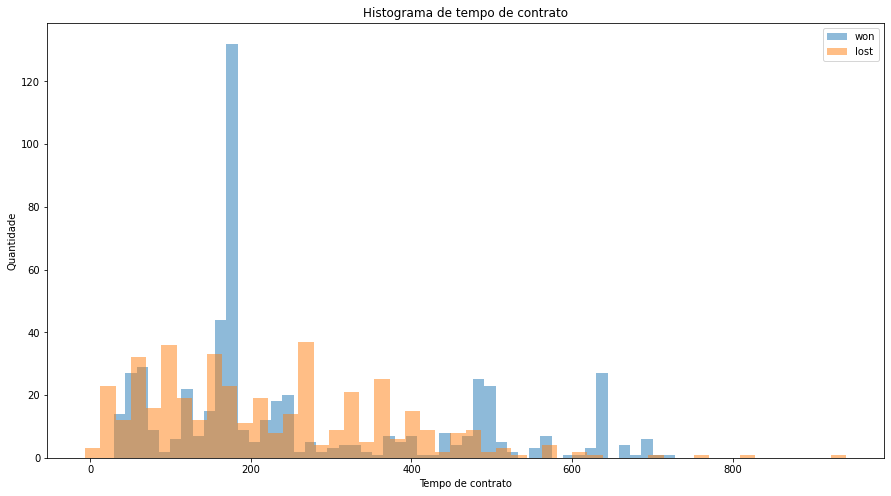

In [64]:
from datetime import datetime
import matplotlib.pyplot as plt

data = pd.read_csv('../../data/data-preprocessed.csv')

data['PESSOA_PIPEDRIVE_contract_end_date'] = pd.to_datetime(data['PESSOA_PIPEDRIVE_contract_end_date'], format='%Y-%m-%d')
data["PESSOA_PIPEDRIVE_contract_start_date"] = pd.to_datetime(data["PESSOA_PIPEDRIVE_contract_start_date"], format='%Y-%m-%d')
    
data['PESSOA_PIPEDRIVE_contract_end_date'].fillna(datetime.now(), inplace=True)
data['PESSOA_PIPEDRIVE_contract_start_date'].fillna(datetime.now(), inplace=True)

data['tempo_contrato'] = data['PESSOA_PIPEDRIVE_contract_end_date'] - data['PESSOA_PIPEDRIVE_contract_start_date']
data['tempo_contrato'] = data['tempo_contrato'].dt.days
    
plt.figure(figsize=(15,8))

for status in ["won", "lost"]:
    subset = data[data["FUNIL_ASSINATURA_PIPEDRIVE_status"] == status]
    plt.hist(subset["tempo_contrato"], bins=50, alpha=0.5, label=status)
    plt.title("Histograma de tempo de contrato")
    plt.xlabel("Tempo de contrato")
    plt.ylabel("Quantidade")
    plt.legend(loc="upper right")

plt.show()

A maior parte das pessoas que saíram, como mostrado no gráfico, ficou por pouco tempo na plataforma. Como o modelo é treinado nesses dados, isso vai se refletir na hora de prever quanto tempo que pessoas que estão na plataforma vão continuar, e a previsão na maioria das vezes vai ser que elas vão sair em pouco tempo, o que pode não refletir a realidade.